<a href="https://colab.research.google.com/github/Haikalasad/Nginx-Log-Attack-Detection-With-CNN/blob/main/Ngninx_log_attack_detetion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
from datetime import datetime, timedelta

def parse_log(file_path, chunk_size=50000):
    chunks = []
    chunk = []

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            match = re.match(r'^(\S+) - - \[(.*?)\] \"(\S+) (.*?) (HTTP/\S+)\" (\d+) (\d+) \"(.*?)\" \"(.*?)\"$', line)
            if match:
                chunk.append([
                    match.group(1),  # IP
                    match.group(2),  # Timestamp
                    match.group(3),  # Method
                    match.group(4),  # URL
                    int(match.group(6)),  # Status
                    match.group(9)   # User Agent
                ])

            if (i + 1) % chunk_size == 0:
                chunks.append(pd.DataFrame(chunk, columns=['ip', 'timestamp', 'method', 'url', 'status', 'user_agent']))
                chunk = []

        if chunk:
            chunks.append(pd.DataFrame(chunk, columns=['ip', 'timestamp', 'method', 'url', 'status', 'user_agent']))

    return pd.concat(chunks, ignore_index=True)

def label_data(df):
    # Aturan deteksi serangan
    patterns = {
        'SQL Injection': r'(?i)\b(UNION|SELECT|INSERT|DELETE|UPDATE|DROP|AND|OR|CONCAT)\b(?=.*[=;\'"])',
        'XSS': r'<script>|%3Cscript%3E',
        'Directory Traversal': r'\.\./',
        'Malicious URL': r'Slot|slot|Zeus|zeus|Jackpot|JP|WD|JOIN'
    }

    df['label'] = 'Normal'

    for label, pattern in patterns.items():
        matches = df['url'].str.contains(pattern, flags=re.IGNORECASE, na=False, regex=True)
        df.loc[matches, 'label'] = label

    return df

def detect_brute_force(df, time_frame_minutes=5, threshold=5):

    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
    brute_force_logs = []

    failed_attempts = df[df['status'].isin([401, 403])]

    for ip, group in failed_attempts.groupby('ip'):
        group = group.sort_values('timestamp')
        access_count = 1
        start_time = group['timestamp'].iloc[0]

        for i in range(1, len(group)):
            if (group['timestamp'].iloc[i] - start_time) <= timedelta(minutes=time_frame_minutes):
                access_count += 1
            else:
                access_count = 1
                start_time = group['timestamp'].iloc[i]

            if access_count > threshold:
                brute_force_logs.extend(group.iloc[i - threshold + 1:i + 1].index.tolist())
                break

    df.loc[brute_force_logs, 'label'] = 'Brute Force'
    return df



file_path = 'old.log'
log_df = parse_log(file_path, chunk_size=10000)
labeled_df = label_data(log_df)
labeled_df = detect_brute_force(labeled_df)

output_path = 'labeled_nginx_log_2.csv'
labeled_df.to_csv(output_path, index=False)
print(f"Dataset labeled tersimpan di {output_path}")



C:\Users\62812\AppData\Local\Temp\ipykernel_7084\205765155.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = df['url'].str.contains(pattern, flags=re.IGNORECASE, na=False, regex=True)


Dataset labeled tersimpan di labeled_nginx_log_2.csv


In [ ]:
import pandas as pd

input_file = "labeled_nginx_log_2.csv"
output_file = "sampled_labeled_nginx_log_2.csv"

try:
    df = pd.read_csv(input_file)

    sampled_df = df.sample(frac=0.1, random_state=42)

    sampled_df.to_csv(output_file, index=False)
    print(f"Sampled 10% dataset saved to {output_file}")

except FileNotFoundError:
    print(f"File {input_file} not found. Please ensure the file exists.")


Sampled 10% dataset saved to sampled_labeled_nginx_log_2.csv


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta

# **Read Labeled Dataset**

In [ ]:
df=pd.read_csv('labeled_nginx_log_2.csv')

In [ ]:
df

,ip,timestamp,method,url,status,user_agent,label
0,66.249.79.63,2022-12-16 17:04:10+07:00,GET,/robots.txt,404,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Normal
1,10.220.34.198,2022-12-16 17:04:12+07:00,GET,/,200,Mozilla/5.0 (compatible; PRTG Network Monitor ...,Normal
2,10.220.34.198,2022-12-16 17:05:16+07:00,GET,/,200,Mozilla/5.0 (compatible; PRTG Network Monitor ...,Normal
3,114.5.105.122,2022-12-16 17:06:07+07:00,GET,/,200,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Normal
4,114.5.105.122,2022-12-16 17:06:08+07:00,GET,/wp-content/plugins/elementor/assets/lib/eicon...,200,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Normal
...,...,...,...,...,...,...,...
11364746,10.220.5.92,2024-09-17 07:41:14+07:00,GET,/robots.txt,200,Mozilla/5.0 (compatible;PetalBot;+https://webm...,Normal
11364747,10.220.5.92,2024-09-17 07:45:28+07:00,GET,/,301,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,Normal
11364748,10.220.5.92,2024-09-17 07:50:28+07:00,GET,/,200,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,Normal
11364749,10.220.5.92,2024-09-17 07:55:28+07:00,HEAD,/,200,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,Normal


# **Count Label**

In [ ]:
label_counts = df['label'].value_counts()
print("Jumlah tiap label:")
print(label_counts)

Jumlah tiap label:
label
Normal                 11134440
Malicious URL            219564
Brute Force                5030
Directory Traversal        3426
SQL Injection              1663
XSS                         628
Name: count, dtype: int64


In [ ]:
def extract_features(df):

    df['user_agent'] = df['user_agent'].fillna('')

    # Fitur 1: Panjang URI
    df['uri_length'] = df['url'].apply(len)

    # Fitur 2: Jumlah parameter dalam URI
    df['param_count'] = df['url'].apply(lambda x: x.count('?') + x.count('&'))

    # Fitur 3: Panjang User-Agent
    df['user_agent_length'] = df['user_agent'].apply(len)

    # Fitur 4: HTTP Method (one-hot encoding)
    http_methods = pd.get_dummies(df['method'], prefix='method')
    df = pd.concat([df, http_methods], axis=1)

    # Fitur 5: Kategori Status Code
    df['status_category'] = df['status'] // 100
    status_category_dummies = pd.get_dummies(df['status_category'], prefix='status_cat')
    df = pd.concat([df, status_category_dummies], axis=1)

    # Fitur 6: Frekuensi kemunculan IP
    ip_counts = df['ip'].value_counts()
    df['ip_frequency'] = df['ip'].map(ip_counts)

    # Fitur 7: Waktu akses (jam)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

    # Fitur 8: Label (target)
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])

    df = df.drop(['url', 'user_agent', 'method', 'status', 'timestamp', 'label', 'ip'], axis=1)
    return df, label_encoder


# Ekstraksi fitur

features_df, label_encoder = extract_features(df)

features_df.to_csv('features_dataset.csv', index=False)
print("Fitur berhasil diekstraksi dan disimpan ke 'features_dataset.csv'.")



Fitur berhasil diekstraksi dan disimpan ke 'features_dataset.csv'.


In [ ]:
# features_df = pd.read_csv('features_dataset.csv')
file_path = '/content/drive/My Drive/Sistem Keamanan Cerdas/Tugas Besar/features_dataset.csv'

features_df = pd.read_csv(file_path)

In [ ]:
features_df


,uri_length,param_count,user_agent_length,method_CONNECT,method_DELETE,method_GET,method_HEAD,method_OPTIONS,method_PATCH,method_POST,...,method_PUT,method_SSTP_DUPLEX_POST,status_category,status_cat_2,status_cat_3,status_cat_4,status_cat_5,ip_frequency,hour,label_encoded
0,11,0,72,False,False,True,False,False,False,False,...,False,False,4,False,False,True,False,6234,17,3
1,1,0,74,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,650724,17,3
2,1,0,74,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,650724,17,3
3,1,0,135,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,10,17,3
4,73,1,135,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,10,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364746,11,0,82,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,2059382,7,3
11364747,1,0,70,False,False,True,False,False,False,False,...,False,False,3,False,True,False,False,2059382,7,3
11364748,1,0,70,False,False,True,False,False,False,False,...,False,False,2,True,False,False,False,2059382,7,3
11364749,1,0,70,False,False,False,True,False,False,False,...,False,False,2,True,False,False,False,2059382,7,3


In [ ]:
label_counts = features_df['label_encoded'].value_counts()
print("Jumlah data untuk setiap label:")
print(label_counts)


Jumlah data untuk setiap label:
label_encoded
3    11134440
2      219564
0        5030
1        3426
4        1663
5         628
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_df[['uri_length', 'user_agent_length', 'ip_frequency']] = scaler.fit_transform(
    features_df[['uri_length', 'user_agent_length', 'ip_frequency']]
)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Pisahkan fitur dan label
X = features_df.drop('label_encoded', axis=1)
y = features_df['label_encoded']

# Target jumlah data untuk setiap kelas
target_count = 439128

# Undersample kelas mayoritas (kelas 3)
undersampler = RandomUnderSampler(sampling_strategy={3: target_count}, random_state=42)
X_majority_resampled, y_majority_resampled = undersampler.fit_resample(X, y)

# Filter data kelas non-mayoritas
non_majority_classes = pd.DataFrame(X_majority_resampled)
non_majority_classes['label_encoded'] = y_majority_resampled

# Oversample semua kelas minoritas untuk mencapai target_count
oversampler = RandomOverSampler(sampling_strategy={label: target_count for label in y.unique()}, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(
    non_majority_classes.drop('label_encoded', axis=1),
    non_majority_classes['label_encoded']
)

print("Jumlah data sebelum resampling:")
print(y.value_counts())

print("\nJumlah data setelah resampling:")
print(y_resampled.value_counts())

# Split data menjadi training dan testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("\nJumlah data pelatihan:", len(X_train))
print("Jumlah data pengujian:", len(X_test))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Jumlah data sebelum resampling:
label_encoded
3    11134440
2      219564
0        5030
1        3426
4        1663
5         628
Name: count, dtype: int64

Jumlah data setelah resampling:
label_encoded
0    439128
1    439128
2    439128
3    439128
4    439128
5    439128
Name: count, dtype: int64

Jumlah data pelatihan: 2107814
Jumlah data pengujian: 526954


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder.transform(y_test.values.reshape(-1, 1))

X_train_cnn = np.expand_dims(X_train.values, axis=2).astype('float32')
X_test_cnn = np.expand_dims(X_test.values, axis=2).astype('float32')

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_encoded))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_encoded))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Membangun model CNN
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Latih model dengan subset data
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    verbose=1
)


Epoch 1/5
32935/32935 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - accuracy: 0.7384 - loss: 0.7181 - val_accuracy: 0.8007 - val_loss: 0.5371
Epoch 2/5
32935/32935 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - accuracy: 0.7890 - loss: 0.5871 - val_accuracy: 0.8016 - val_loss: 0.5341
Epoch 3/5
32935/32935 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - accuracy: 0.7954 - loss: 0.5649 - val_accuracy: 0.8117 - val_loss: 0.5055
Epoch 4/5
32935/32935 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - accuracy: 0.7982 - loss: 0.5557 - val_accuracy: 0.7985 - val_loss: 0.5445
Epoch 5/5
32935/32935 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - accuracy: 0.7999 - loss: 0.5499 - val_accuracy: 0.8127 - val_loss: 0.4935


In [ ]:
# Evaluasi model pada data pengujian
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 81.27%


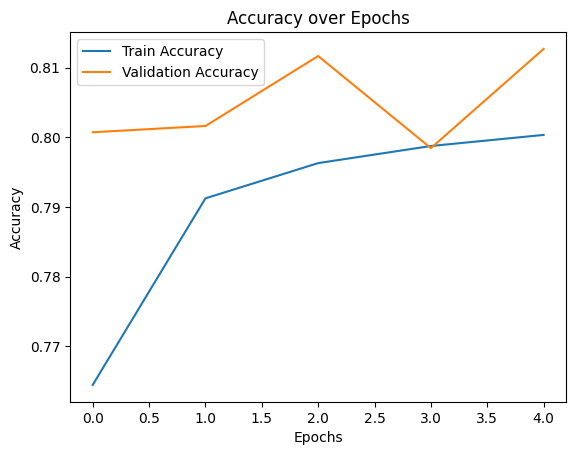

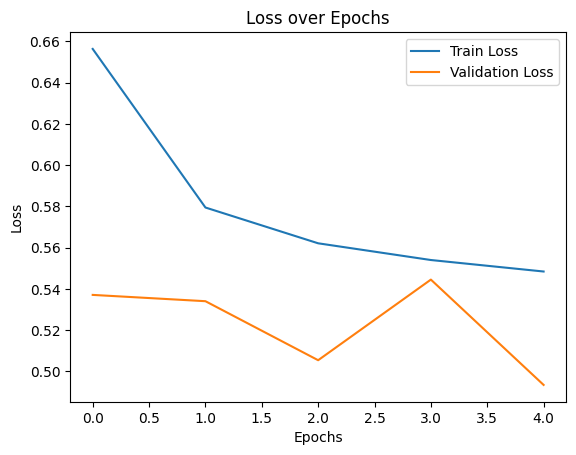

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


16468/16468 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
[[82354   941     0  4379    50    51]
 [ 4757 67109    19   830  1406 13240]
 [ 1173  1825 78020  4901   504  1411]
 [12924   944  4895 67825   972   363]
 [  648   740 31585   100 47173  7929]
 [    0   543     0     0  1566 85777]]


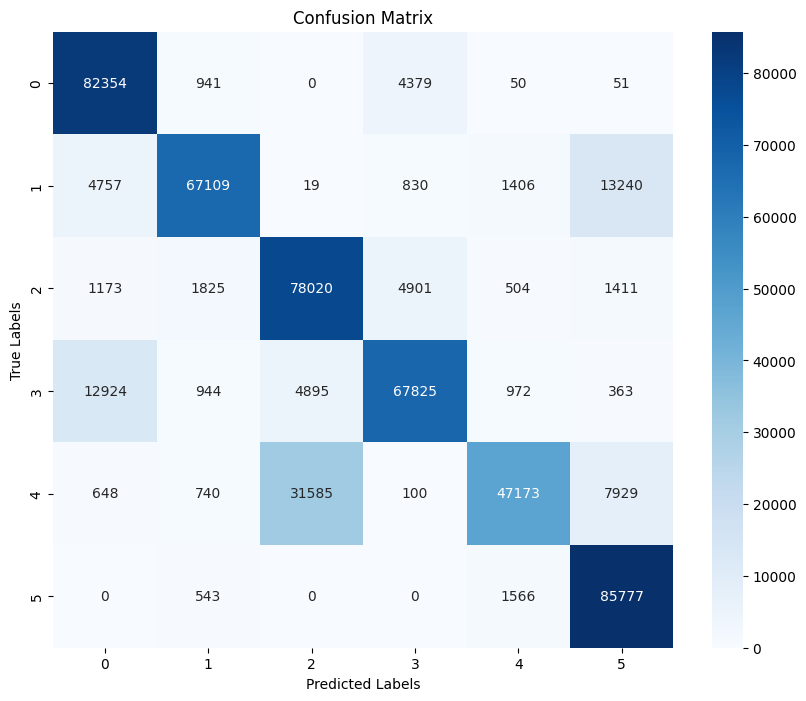

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi data pengujian
y_pred_probs = model.predict(X_test_cnn, verbose=1)  # Prediksi probabilitas
y_pred_labels = np.argmax(y_pred_probs, axis=1)      # Ambil label prediksi
y_test_labels = np.argmax(y_test_encoded, axis=1)    # Konversi one-hot ke label asli

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print (conf_matrix)
# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=onehot_encoder.categories_[0], yticklabels=onehot_encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=[str(cls) for cls in onehot_encoder.categories_[0]]))

# Accuracy Score
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"\nAccuracy Score: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     87775
           1       0.93      0.77      0.84     87361
           2       0.68      0.89      0.77     87834
           3       0.87      0.77      0.82     87923
           4       0.91      0.53      0.67     88175
           5       0.79      0.98      0.87     87886

    accuracy                           0.81    526954
   macro avg       0.83      0.81      0.81    526954
weighted avg       0.83      0.81      0.81    526954


Accuracy Score: 81.27%


In [ ]:
# Simpan model
model.save('cnn_log_classification_model.h5')
print("Model telah disimpan.")
